In [27]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
# Change the style of plot
plt.style.use('seaborn-darkgrid')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [28]:
# Scaling
from sklearn.preprocessing import RobustScaler, StandardScaler

# Train Test Split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve

# Metrics
from sklearn.metrics import accuracy_score, classification_report, roc_curve,confusion_matrix

# Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import log_loss, classification_report
from sklearn.model_selection import train_test_split

In [29]:
import os
save_folder = "../figures/neural_net/"
os.path.isdir(save_folder)

True

In [30]:
filename = '../datasets/heart.csv'
df = pd.read_csv(filename)

In [31]:
df.head(3)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1


In [32]:
# creating a copy of df
df1_copy = df

# define the columns to be encoded and scaled (defined before)
categorial_features = ['sex','exng','caa','cp','fbs','restecg','slp','thall']
continuous_features = ["age","trtbps","chol","thalachh","oldpeak"]

# encoding the categorical columns (one hot encoding)
df1_copy = pd.get_dummies(df1_copy, columns = categorial_features, drop_first = True)

# seperate features with target
X = df1_copy.drop(['output'],axis=1)
y = df1_copy[['output']]
# instantiating the scaler
scaler = RobustScaler()
# scaler = StandardScaler()

# scaling the continuous featuree
X[continuous_features] = scaler.fit_transform(X[continuous_features])

In [33]:
#separate data for testing and training 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 0)
y_train = y_train.squeeze(1)
y_test = y_test.squeeze(1)
print("The shape of X_train is      ", X_train.shape)
print("The shape of X_test is       ",X_test.shape)
print("The shape of y_train is      ",y_train.shape)
print("The shape of y_test is       ",y_test.shape)

The shape of X_train is       (227, 22)
The shape of X_test is        (76, 22)
The shape of y_train is       (227,)
The shape of y_test is        (76,)


In [34]:
from mlrose_hiive.algorithms.decay import ExpDecay
from mlrose_hiive.neural import NeuralNetwork

In [38]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(0.01, 1.0, 15)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure(figsize=(6,4))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, shuffle=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
#     plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## Gradient Descent 

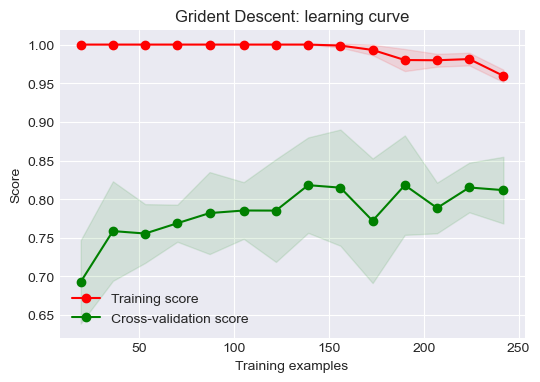

In [52]:
clf =  NeuralNetwork(hidden_nodes=[10,], activation='relu',
                       algorithm='gradient_descent', max_iters=200,
                       bias=True, is_classifier=True, learning_rate=0.01,
                       early_stopping=False, clip_max=1e10,random_state =102,
                       max_attempts=100, curve=False)
title = 'Grident Descent: learning curve'
plt = plot_learning_curve(clf,title,X,y.squeeze(1),n_jobs=-1)
plt.savefig(save_folder+ "GD_learning_curve.pdf")
plt.show()

In [57]:
start = 2
end = 303
step = 2
iterations = np.arange(start,end,step).astype(int)

train_losses, val_losses, train_times = [], [], []
for it in range(start,end,step):
    nn =  NeuralNetwork(hidden_nodes=[10,], activation='relu',
                       algorithm='gradient_descent', max_iters=it,
                       bias=True, is_classifier=True, learning_rate=0.01,
                       early_stopping=False, clip_max=1e10,random_state =102,
                       max_attempts=100, curve=False)
    # Train on current training fold and append training time
    start_time = time.time()
    nn.fit(X_train, y_train)
    train_times.append(time.time() - start_time)
    
    # Compute and append training and validation log losses
    train_loss = log_loss(y_train, nn.predict(X_train))
    val_loss = log_loss(y_test, nn.predict(X_test))
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print('{} - train loss = {:.3f}, val loss = {:.3f}'.format(it, train_loss, val_loss))

2 - train loss = 13.238, val loss = 12.725
4 - train loss = 6.847, val loss = 7.726
6 - train loss = 6.847, val loss = 5.908
8 - train loss = 6.086, val loss = 5.908
10 - train loss = 5.630, val loss = 4.999
12 - train loss = 5.478, val loss = 4.999
14 - train loss = 5.325, val loss = 4.999
16 - train loss = 5.478, val loss = 4.545
18 - train loss = 5.173, val loss = 4.545
20 - train loss = 5.021, val loss = 4.999
22 - train loss = 4.869, val loss = 5.908
24 - train loss = 4.869, val loss = 5.908
26 - train loss = 4.869, val loss = 5.908
28 - train loss = 4.869, val loss = 5.908
30 - train loss = 4.565, val loss = 5.908
32 - train loss = 4.413, val loss = 5.908
34 - train loss = 4.717, val loss = 5.908
36 - train loss = 4.565, val loss = 5.908
38 - train loss = 4.565, val loss = 5.454
40 - train loss = 4.565, val loss = 5.454
42 - train loss = 4.413, val loss = 5.908
44 - train loss = 4.260, val loss = 5.454
46 - train loss = 4.260, val loss = 5.454
48 - train loss = 4.260, val loss = 

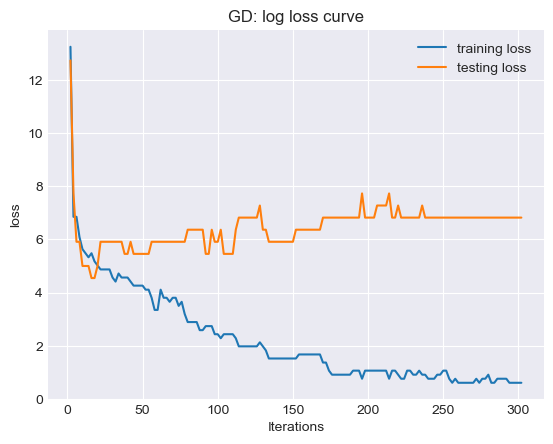

In [59]:
plt.plot(iterations,train_losses,label='training loss')
plt.plot(iterations,val_losses,label='testing loss')
plt.title("GD: log loss curve")
plt.legend(loc='best')
plt.xlabel("Iterations")
plt.ylabel("loss")
plt.savefig(save_folder+"GD_loss_curve.pdf")

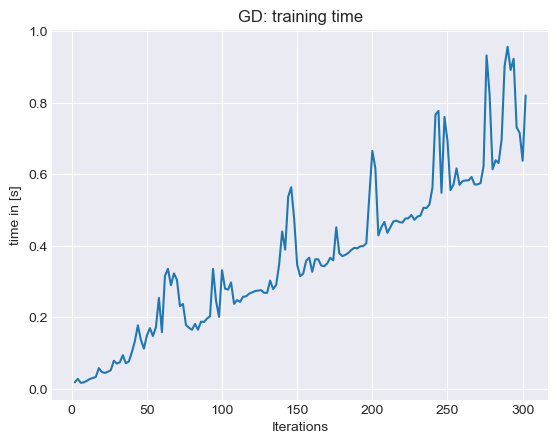

In [62]:
plt.plot(iterations,train_times)
plt.title("GD: training time")
# plt.legend(loc='best')
plt.xlabel("Iterations")
plt.ylabel("time in [s]")
plt.savefig(save_folder+"GD_train_time.pdf")

## Random Hill Climing

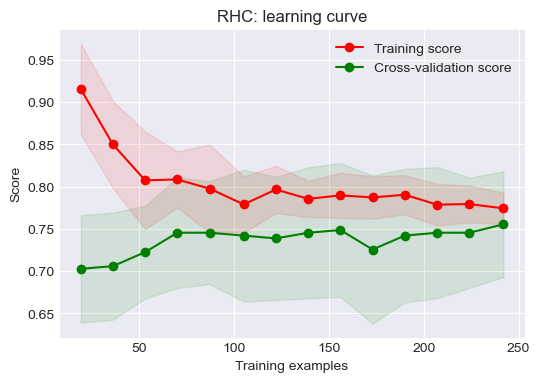

In [79]:
RHC =  NeuralNetwork(hidden_nodes=[10,], activation='relu',
                       algorithm='random_hill_climb', max_iters=6000,
                       bias=True, is_classifier=True,restarts=10, learning_rate=0.1,
                       early_stopping=True, clip_max=1e10,random_state =102,
                       max_attempts=100, curve=False)
title = 'RHC: learning curve'
plt = plot_learning_curve(RHC,title,X,y.squeeze(1),n_jobs=-1)
plt.savefig(save_folder+ "RHC_learning_curve.pdf")
plt.show()

In [211]:
start = 2
end = 5000
step = 100
iterations = np.arange(start,end,step).astype(int)

train_losses, val_losses, train_times = [], [], []
for it in range(start,end,step):
    RHC =  NeuralNetwork(hidden_nodes=[10,], activation='relu',
                       algorithm='random_hill_climb', max_iters=it,
                       bias=True, is_classifier=True,restarts=10, learning_rate=0.1,
                       early_stopping=False, clip_max=1e10,random_state =102,
                       max_attempts=100, curve=False)
    # Train on current training fold and append training time
    start_time = time.time()
    RHC.fit(X_train, y_train)
    train_times.append(time.time() - start_time)
    
    # Compute and append training and validation log losses
    train_loss = log_loss(y_train, RHC.predict(X_train))
    val_loss = log_loss(y_test, RHC.predict(X_test))
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print('{} - train loss = {:.3f}, val loss = {:.3f}'.format(it, train_loss, val_loss))

2 - train loss = 15.672, val loss = 17.270
102 - train loss = 14.455, val loss = 15.452
202 - train loss = 12.781, val loss = 13.179
302 - train loss = 10.955, val loss = 10.907
402 - train loss = 10.042, val loss = 10.453
502 - train loss = 9.738, val loss = 9.544
602 - train loss = 7.608, val loss = 6.817
702 - train loss = 6.543, val loss = 8.180
802 - train loss = 6.543, val loss = 6.817
902 - train loss = 6.847, val loss = 6.362
1002 - train loss = 6.238, val loss = 6.362
1102 - train loss = 5.325, val loss = 5.908
1202 - train loss = 5.325, val loss = 4.999
1302 - train loss = 5.630, val loss = 4.545
1402 - train loss = 4.717, val loss = 4.999
1502 - train loss = 4.869, val loss = 4.545
1602 - train loss = 4.869, val loss = 4.545
1702 - train loss = 4.869, val loss = 4.545
1802 - train loss = 4.260, val loss = 4.545
1902 - train loss = 4.565, val loss = 4.545
2002 - train loss = 4.260, val loss = 5.908
2102 - train loss = 3.652, val loss = 6.362
2202 - train loss = 3.804, val los

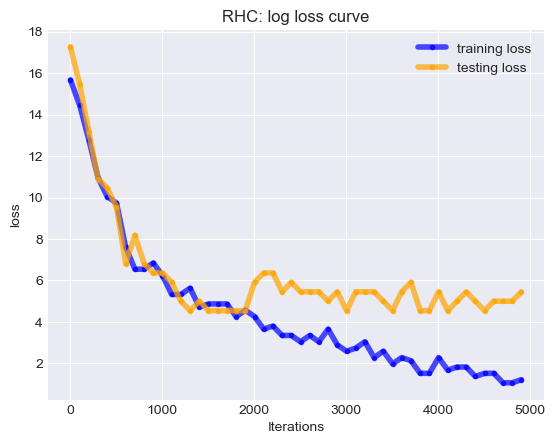

In [213]:
plt.plot(iterations,train_losses,marker='.', color='blue', linewidth=4, alpha=0.7,label='training loss')
plt.plot(iterations,val_losses,marker='.', color='orange', linewidth=4, alpha=0.7,label='testing loss')
plt.title("RHC: log loss curve")
plt.legend(loc='best')
plt.xlabel("Iterations")
plt.ylabel("loss")
plt.savefig(save_folder+"RHC_loss_curve.pdf")

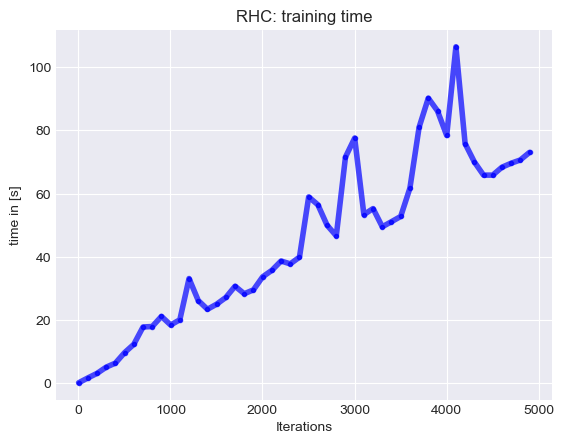

In [214]:
plt.plot(iterations,train_times,marker='.', color='blue', linewidth=4, alpha=0.7)
plt.title("RHC: training time")
# plt.legend(loc='best')
plt.xlabel("Iterations")
plt.ylabel("time in [s]")
plt.savefig(save_folder+"RHC_train_time.pdf")

In [215]:

lrs = [1.0,0.1,0.01,0.001]
restarts = [1,5,10,20]
train_acc, val_acc = np.zeros((len(lrs),len(restarts))),np.zeros((len(lrs),len(restarts)))
for i,lr in tqdm(enumerate(lrs)):
    for j,restart in enumerate(restarts):
        RHC =  NeuralNetwork(hidden_nodes=[10,], activation='relu',
                           algorithm='random_hill_climb', max_iters=5000,
                           bias=True, is_classifier=True,restarts=restart, learning_rate=lr,
                           early_stopping=True, clip_max=1e10,random_state =102,
                           max_attempts=100, curve=False)

        RHC.fit(X_train, y_train)

        # Compute and append training and validation log losses
        train_pre =  round(100*accuracy_score(y_train,RHC.predict(X_train)),1)
        val_pred = round(100*accuracy_score(y_test,RHC.predict(X_test)),1)
        train_acc[i,j] = train_pre
        val_acc[i,j]= val_pred
#         print('{} - train loss = {:.3f}, val loss = {:.3f}'.format(it, train_loss, val_loss))

4it [21:56, 329.19s/it]


In [216]:
val_acc

array([[82.9, 82.9, 80.3, 77.6],
       [84.2, 84.2, 85.5, 85.5],
       [69.7, 69.7, 69.7, 73.7],
       [50. , 50. , 50. , 51.3]])

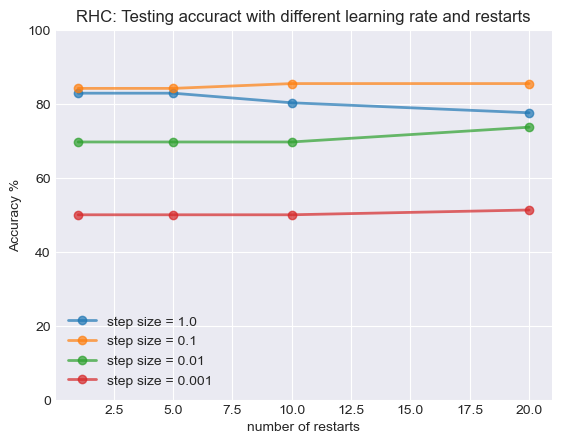

In [219]:
plt.plot(restarts,val_acc[0],label='step size = 1.0', marker='o',  linewidth=2, alpha=0.7)
plt.plot(restarts,val_acc[1],label='step size = 0.1', marker='o',  linewidth=2, alpha=0.7)
plt.plot(restarts,val_acc[2],label='step size = 0.01', marker='o',  linewidth=2, alpha=0.7)
plt.plot(restarts,val_acc[3],label='step size = 0.001', marker='o',  linewidth=2, alpha=0.7)
ax = plt.gca()
ax.set_ylim([0, 100])
# ax.set_xscale('log')
plt.title("RHC: Testing accuract with different learning rate and restarts")
plt.legend(loc='best')
plt.xlabel("number of restarts")
plt.ylabel("Accuracy %")
plt.savefig(save_folder+"RHC_acc_lr_restart.pdf")

## simulated annealing

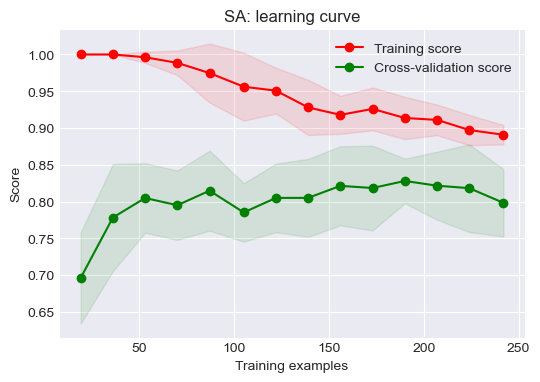

In [117]:
# Define SA exponential decay schedule
exp_decay = ExpDecay(init_temp=100,
                     exp_const=0.1,
                     min_temp=0.001)
SA =  NeuralNetwork(hidden_nodes=[10,], activation='relu',
                       algorithm='simulated_annealing', max_iters=6000,
                       bias=True, is_classifier=True,schedule=exp_decay, learning_rate=0.1,
                       early_stopping=False, clip_max=1e10,random_state =102,
                       max_attempts=100, curve=False)
title = 'SA: learning curve'
plt = plot_learning_curve(SA,title,X,y.squeeze(1),n_jobs=-1)
plt.savefig(save_folder+ "SA_learning_curve.pdf")
plt.show()

In [114]:
lrs = [10.0,1.0,0.1,0.01,0.001]
exp_decay = ExpDecay(init_temp=100,
                     exp_const=0.1,
                     min_temp=0.001)
acc_list = []
for i,lr in tqdm(enumerate(lrs)):

    SA =  NeuralNetwork(hidden_nodes=[10,], activation='relu',
                           algorithm='simulated_annealing', max_iters=6000,
                           bias=True, is_classifier=True,schedule=exp_decay, learning_rate=lr,
                           early_stopping=False, clip_max=1e10,random_state =102,
                           max_attempts=100, curve=False)

    SA.fit(X_train, y_train)
    val_pred = round(100*accuracy_score(y_test,SA.predict(X_test)),1)
    acc_list.append(val_pred)


5it [00:58, 11.64s/it]


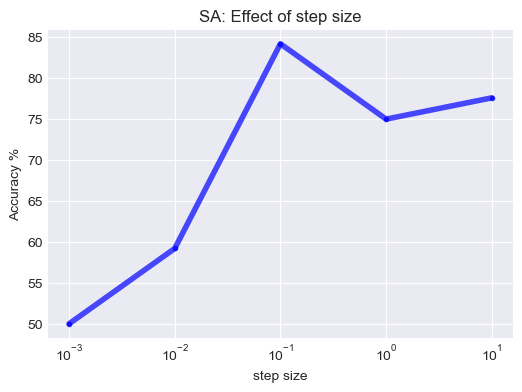

In [116]:
plt.figure(figsize=(6,4))

# plt.plot(lrs,acc_list)
plt.plot(lrs, acc_list, marker='.', color='blue', linewidth=4, alpha=0.7)


# plt.legend(loc='best')
ax = plt.gca()
# ax.set_ylim([30, 100])
ax.set_xscale('log')
plt.title("SA: Effect of step size")
# plt.legend(loc='best')
plt.xlabel("step size")
plt.ylabel("Accuracy %")
plt.savefig(save_folder+"SA_learning_rate.pdf")

In [118]:
start = 2
end = 6000
step = 100
iterations = np.arange(start,end,step).astype(int)
exp_decay = ExpDecay(init_temp=100,
                     exp_const=0.1,
                     min_temp=0.001)

train_losses, val_losses, train_times = [], [], []
for it in range(start,end,step):
    SA =  NeuralNetwork(hidden_nodes=[10,], activation='relu',
                           algorithm='simulated_annealing', max_iters=it,
                           bias=True, is_classifier=True,schedule=exp_decay, learning_rate=0.1,
                           early_stopping=False, clip_max=1e10,random_state =102,
                           max_attempts=100, curve=False)
    # Train on current training fold and append training time
    start_time = time.time()
    SA.fit(X_train, y_train)
    train_times.append(time.time() - start_time)
    
    # Compute and append training and validation log losses
    train_loss = log_loss(y_train, SA.predict(X_train))
    val_loss = log_loss(y_test, SA.predict(X_test))
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print('{} - train loss = {:.3f}, val loss = {:.3f}'.format(it, train_loss, val_loss))

2 - train loss = 15.824, val loss = 18.178
102 - train loss = 15.520, val loss = 16.815
202 - train loss = 14.303, val loss = 17.270
302 - train loss = 12.933, val loss = 14.997
402 - train loss = 12.172, val loss = 14.088
502 - train loss = 10.803, val loss = 12.270
602 - train loss = 9.890, val loss = 10.907
702 - train loss = 9.738, val loss = 9.998
802 - train loss = 8.521, val loss = 8.635
902 - train loss = 6.999, val loss = 7.726
1002 - train loss = 6.086, val loss = 6.817
1102 - train loss = 6.238, val loss = 6.362
1202 - train loss = 6.086, val loss = 5.908
1302 - train loss = 6.391, val loss = 5.908
1402 - train loss = 5.934, val loss = 6.817
1502 - train loss = 5.782, val loss = 6.362
1602 - train loss = 5.478, val loss = 5.908
1702 - train loss = 5.782, val loss = 5.908
1802 - train loss = 5.782, val loss = 6.362
1902 - train loss = 5.630, val loss = 5.454
2002 - train loss = 5.173, val loss = 6.362
2102 - train loss = 5.478, val loss = 5.454
2202 - train loss = 5.630, val 

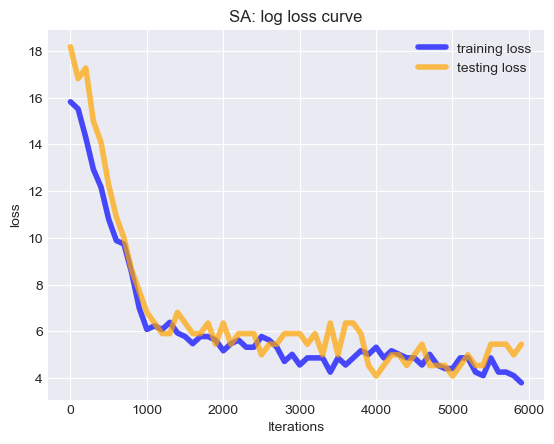

In [119]:
plt.plot(iterations,train_losses,color='blue', linewidth=4, alpha=0.7,label='training loss')
plt.plot(iterations,val_losses,color='orange', linewidth=4, alpha=0.7,label='testing loss')
plt.title("SA: log loss curve")
plt.legend(loc='best')
plt.xlabel("Iterations")
plt.ylabel("loss")
plt.savefig(save_folder+"SA_loss_curve.pdf")

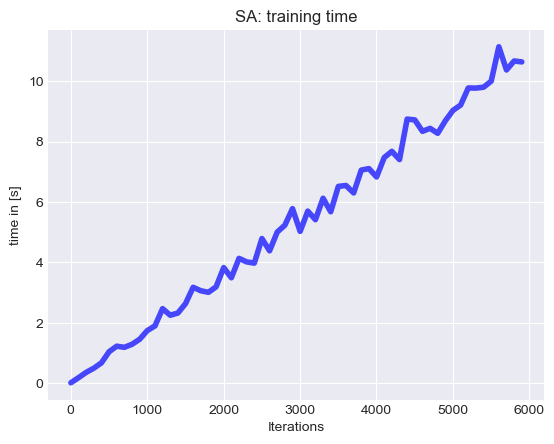

In [120]:
plt.plot(iterations,train_times,color='blue', linewidth=4, alpha=0.7)
plt.title("SA: training time")
# plt.legend(loc='best')
plt.xlabel("Iterations")
plt.ylabel("time in [s]")
plt.savefig(save_folder+"SA_train_time.pdf")

In [103]:

tmps = [10,100,1e4,10e8]
decays = [0.1,0.3,0.5,0.7]
train_acc, val_acc = np.zeros((len(tmps),len(restarts))),np.zeros((len(tmps),len(restarts)))
for i,t in tqdm(enumerate(tmps)):
    for j,dec in tqdm(enumerate(decays)):
        exp_decay = ExpDecay(init_temp=t,
                     exp_const=dec,
                     min_temp=0.01)
        SA =  NeuralNetwork(hidden_nodes=[10,], activation='relu',
                           algorithm='simulated_annealing', max_iters=6000,
                           bias=True, is_classifier=True,schedule=exp_decay, learning_rate=0.1,
                           early_stopping=False, clip_max=1e10,random_state =102,
                           max_attempts=100, curve=False)

        SA.fit(X_train, y_train)

        # Compute and append training and validation log losses
        train_pre =  round(100*accuracy_score(y_train,SA.predict(X_train)),1)
        val_pred = round(100*accuracy_score(y_test,SA.predict(X_test)),1)
        train_acc[i,j] = train_pre
        val_acc[i,j]= val_pred
#         print('{} - train loss = {:.3f}, val loss = {:.3f}'.format(it, train_loss, val_loss))

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:11, 11.53s/it]
2it [00:25, 13.18s/it]
3it [00:42, 14.75s/it]
4it [00:57, 14.34s/it]
1it [00:57, 57.36s/it]
0it [00:00, ?it/s]
1it [00:16, 16.45s/it]
2it [00:32, 16.16s/it]
3it [00:47, 15.82s/it]
4it [01:00, 15.13s/it]
2it [01:57, 59.23s/it]
0it [00:00, ?it/s]
1it [00:15, 15.02s/it]
2it [00:30, 15.32s/it]
3it [00:45, 14.98s/it]
4it [00:57, 14.46s/it]
3it [02:55, 58.60s/it]
0it [00:00, ?it/s]
1it [00:13, 13.09s/it]
2it [00:26, 13.49s/it]
3it [00:40, 13.63s/it]
4it [00:53, 13.39s/it]
4it [03:49, 57.33s/it]


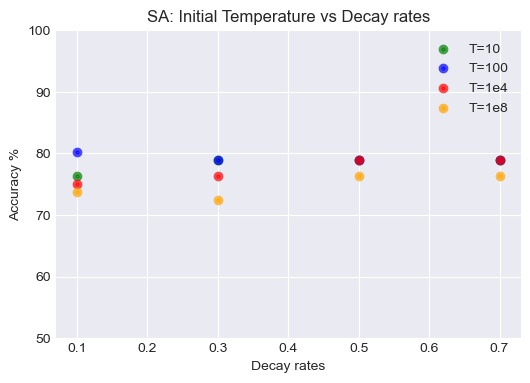

In [108]:
plt.figure(figsize=(6,4))
plt.scatter(decays, val_acc[0], marker='.', color='green', linewidth=4, alpha=0.7, label="T=10")
plt.scatter(decays, val_acc[1], marker='.', color='blue', linewidth=4, alpha=0.7, label="T=100")
plt.scatter(decays, val_acc[2], marker='.', color='red', linewidth=4, alpha=0.7, label="T=1e4")
plt.scatter(decays, val_acc[3], marker='.', color='orange', linewidth=4, alpha=0.7, label="T=1e8")

plt.legend(loc='best')
ax = plt.gca()
ax.set_ylim([50, 100])
# ax.set_xscale('log')
plt.xlabel("Decay rates")
plt.ylabel("Accuracy %")
plt.title("SA: Initial Temperature vs Decay rates")
# plt.show()
plt.savefig(save_folder+ "T_and_decays.pdf")

## Genetic Algorithm

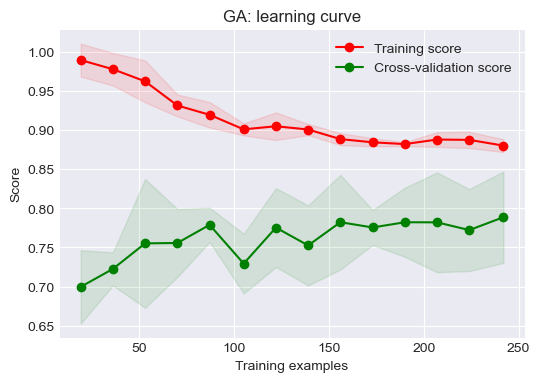

In [209]:
GA =  NeuralNetwork(hidden_nodes=[10,], activation='relu',
                       algorithm='genetic_alg', max_iters=300,
                       bias=True, is_classifier=True,mutation_prob=0.1,
                       early_stopping=True, clip_max=1e10,random_state =102,pop_size =200,
                       max_attempts=100, curve=False)
title = 'GA: learning curve'
plt = plot_learning_curve(GA,title,X,y.squeeze(1),n_jobs=-1)
plt.savefig(save_folder+ "GA_learning_curve.pdf")
plt.show()

In [148]:
GA =  NeuralNetwork(hidden_nodes=[10,], activation='relu',
                       algorithm='genetic_alg', max_iters=300,
                       bias=True, is_classifier=True,mutation_prob=0.2, learning_rate=0.1,
                       early_stopping=True, clip_max=1e10,random_state =102,pop_size =10,
                       max_attempts=100, curve=False)

GA.fit(X_train, y_train)
val_pred = round(100*accuracy_score(y_test,GA.predict(X_test)),1)
print(val_pred)

82.9


In [144]:
lrs = [10.0,1.0,0.1,0.01,0.001]
acc_list = []
for i,lr in tqdm(enumerate(lrs)):

    GA =  NeuralNetwork(hidden_nodes=[10,], activation='relu',
                       algorithm='genetic_alg', max_iters=6000,
                       bias=True, is_classifier=True,mutation_prob=0.2, learning_rate=lr,
                       early_stopping=True, clip_max=1e10,random_state =102,pop_size =200,
                       max_attempts=100, curve=False)

    GA.fit(X_train, y_train)
    val_pred = round(100*accuracy_score(y_test,GA.predict(X_test)),1)
    acc_list.append(val_pred)

5it [02:57, 35.60s/it]


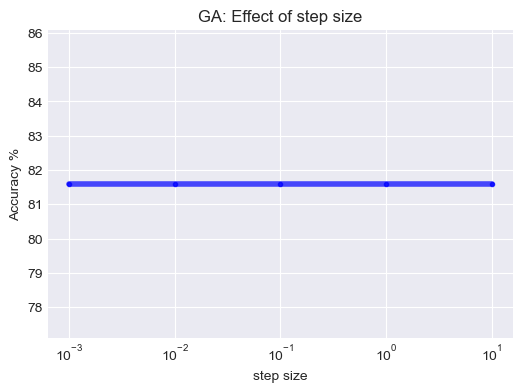

In [145]:
plt.figure(figsize=(6,4))

# plt.plot(lrs,acc_list)
plt.plot(lrs, acc_list, marker='.', color='blue', linewidth=4, alpha=0.7)


# plt.legend(loc='best')
ax = plt.gca()
# ax.set_ylim([30, 100])
ax.set_xscale('log')
plt.title("GA: Effect of step size")
# plt.legend(loc='best')
plt.xlabel("step size")
plt.ylabel("Accuracy %")
plt.savefig(save_folder+"GA_learning_rate.pdf")

In [157]:
pop_sizes = [5,25,125,500]
acc_list = []
train_time = []
for i,pop_size in tqdm(enumerate(pop_sizes)):
    GA =  NeuralNetwork(hidden_nodes=[10,], activation='relu',
                       algorithm='genetic_alg', max_iters=6000,
                       bias=True, is_classifier=True,mutation_prob=0.2, 
                       early_stopping=True, clip_max=1e10,random_state =102,pop_size =pop_size,
                       max_attempts=100, curve=False)
    start = time.time()
    GA.fit(X_train, y_train)
    train_t = time.time() - start
    train_time.append(train_t)
    val_pred = round(100*accuracy_score(y_test,GA.predict(X_test)),1)
    acc_list.append(val_pred) 

4it [02:03, 30.93s/it]


In [158]:
print(train_time)

[1.7740108966827393, 4.354981899261475, 21.90653395652771, 95.68122386932373]


In [159]:
print(acc_list)

[81.6, 73.7, 78.9, 81.6]


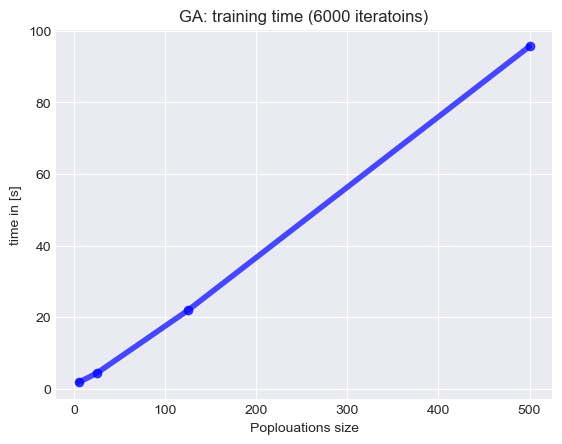

In [164]:
plt.plot(pop_sizes,train_time,marker = 'o',color='blue', linewidth=4, alpha=0.7)
plt.title("GA: training time (6000 iteratoins)")

plt.xlabel("Poplouations size")
plt.ylabel("time in [s]")
plt.savefig(save_folder+"GA_train_time.pdf")

In [177]:
pop_sizes = [5,10,50,100,200]
mutations = [0.01,0.05,0.1,0.2,0.5,0.7]
acc_list = np.zeros((len(pop_sizes),len(mutations)))
for i,pop_size in tqdm(enumerate(pop_sizes)):
    for j, mut in enumerate(mutations):
        GA =  NeuralNetwork(hidden_nodes=[10,], activation='relu',
                           algorithm='genetic_alg', max_iters=300,
                           bias=True, is_classifier=True,mutation_prob=mut, 
                           early_stopping=True, clip_max=1e10,random_state =102,pop_size =pop_size,
                           max_attempts=100, curve=False)
        start = time.time()
        GA.fit(X_train, y_train)
        train_t = time.time() - start
        train_time.append(train_t)
        val_pred = round(100*accuracy_score(y_test,GA.predict(X_test)),1)
        acc_list[i,j]  =val_pred

5it [11:19, 135.81s/it]


In [181]:
acc_list

array([[72.4, 80.3, 77.6, 81.6, 73.7, 67.1],
       [81.6, 85.5, 76.3, 82.9, 73.7, 76.3],
       [80.3, 82.9, 73.7, 76.3, 77.6, 72.4],
       [81.6, 82.9, 82.9, 77.6, 73.7, 75. ],
       [85.5, 81.6, 86.8, 81.6, 72.4, 77.6]])

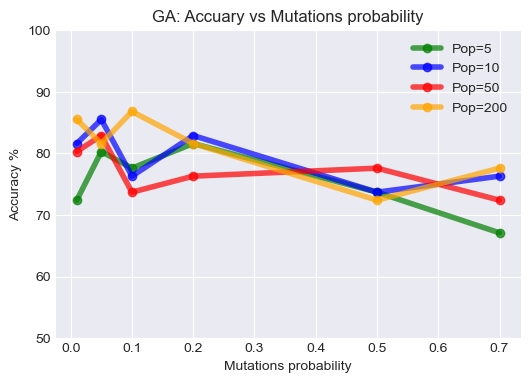

In [179]:
plt.figure(figsize=(6,4))
plt.plot(mutations, acc_list[0], marker='o', color='green', linewidth=4, alpha=0.7, label="Pop=5")
plt.plot(mutations, acc_list[1], marker='o', color='blue', linewidth=4, alpha=0.7, label="Pop=10")
plt.plot(mutations, acc_list[2], marker='o', color='red', linewidth=4, alpha=0.7, label="Pop=50")
# plt.plot(mutations, acc_list[3], marker='o', color='orange', linewidth=4, alpha=0.7, label="Pop=100")
plt.plot(mutations, acc_list[4], marker='o', color='orange', linewidth=4, alpha=0.7, label="Pop=200")

plt.legend(loc='best')
ax = plt.gca()
ax.set_ylim([50, 100])
# ax.set_xscale('log')
plt.xlabel("Mutations probability")
plt.ylabel("Accuracy %")
plt.title("GA: Accuary vs Mutations probability")
# plt.show()
plt.savefig(save_folder+ "GA_Mutation_pop.pdf")

In [193]:
start = 2
end = 503
step = 30
iterations = np.arange(start,end,step).astype(int)

train_losses, val_losses, train_times = [], [], []
for it in range(start,end,step):
    GA =  NeuralNetwork(hidden_nodes=[10,], activation='relu',
                           algorithm='genetic_alg', max_iters=it,
                           bias=True, is_classifier=True,mutation_prob=0.1, 
                           early_stopping=False, clip_max=1e10,random_state =102,pop_size =200,
                           max_attempts=100, curve=False)
    # Train on current training fold and append training time
    start_time = time.time()
    GA.fit(X_train, y_train)
    train_times.append(time.time() - start_time)
    
    # Compute and append training and validation log losses
    train_loss = log_loss(y_train, GA.predict(X_train))
    val_loss = log_loss(y_test, GA.predict(X_test))
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print('{} - train loss = {:.3f}, val loss = {:.3f}'.format(it, train_loss, val_loss))

2 - train loss = 7.760, val loss = 5.454
32 - train loss = 5.782, val loss = 8.180
62 - train loss = 5.021, val loss = 7.726
92 - train loss = 5.021, val loss = 7.726
122 - train loss = 4.717, val loss = 7.726
152 - train loss = 4.717, val loss = 7.726
182 - train loss = 4.717, val loss = 6.817
212 - train loss = 4.717, val loss = 6.817
242 - train loss = 4.565, val loss = 5.908
272 - train loss = 4.412, val loss = 5.454
302 - train loss = 4.260, val loss = 4.545
332 - train loss = 4.260, val loss = 8.180
362 - train loss = 3.804, val loss = 7.271
392 - train loss = 3.804, val loss = 7.271
422 - train loss = 3.804, val loss = 7.271
452 - train loss = 3.804, val loss = 7.271
482 - train loss = 3.804, val loss = 7.271


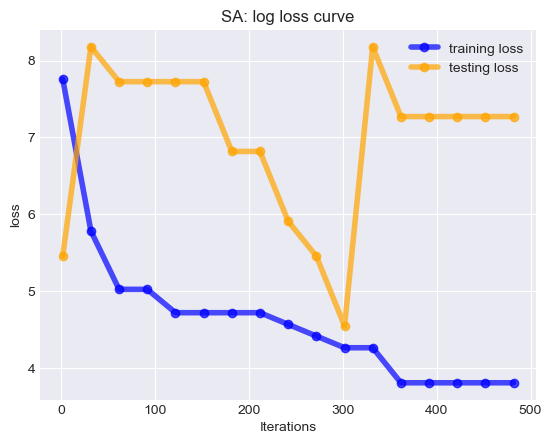

In [195]:
plt.plot(iterations,train_losses,color='blue',marker='o', linewidth=4, alpha=0.7,label='training loss')
plt.plot(iterations,val_losses,color='orange',marker='o', linewidth=4, alpha=0.7,label='testing loss')
plt.title("SA: log loss curve")
plt.legend(loc='best')
plt.xlabel("Iterations")
plt.ylabel("loss")
plt.savefig(save_folder+"SA_loss_curve.pdf")

## Conclusion

In [201]:
GD =  NeuralNetwork(hidden_nodes=[10,], activation='relu',
                       algorithm='gradient_descent', max_iters=18,
                       bias=True, is_classifier=True, learning_rate=0.01,
                       early_stopping=False, clip_max=1e10,random_state =102,
                       max_attempts=100, curve=False)

GD.fit(X_train,y_train)

print(100*accuracy_score(y_test,GD.predict(X_test)))

86.8421052631579


In [202]:
%timeit GD.fit(X_train,y_train)

77.8 ms ± 8.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [203]:
RHC =  NeuralNetwork(hidden_nodes=[10,], activation='relu',
                       algorithm='random_hill_climb', max_iters=5000,
                       bias=True, is_classifier=True,restarts=10, learning_rate=0.1,
                       early_stopping=True, clip_max=1e10,random_state =102,
                       max_attempts=100, curve=False)

RHC.fit(X_train,y_train)

print(100*accuracy_score(y_test,RHC.predict(X_test)))

85.52631578947368


In [204]:
%timeit RHC.fit(X_train,y_train)

1min 54s ± 2.08 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [205]:

exp_decay = ExpDecay(init_temp=100,
                     exp_const=0.1,
                     min_temp=0.001)
SA =  NeuralNetwork(hidden_nodes=[10,], activation='relu',
                       algorithm='simulated_annealing', max_iters=5000,
                       bias=True, is_classifier=True,schedule=exp_decay, learning_rate=0.1,
                       early_stopping=False, clip_max=1e10,random_state =102,
                       max_attempts=100, curve=False)

SA.fit(X_train,y_train)

print(100*accuracy_score(y_test,SA.predict(X_test)))

88.1578947368421


In [206]:
%timeit SA.fit(X_train,y_train)

13.3 s ± 153 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [210]:
GA =  NeuralNetwork(hidden_nodes=[10,], activation='relu',
                       algorithm='genetic_alg', max_iters=300,
                       bias=True, is_classifier=True,mutation_prob=0.1,
                       early_stopping=True, clip_max=1e10,random_state =102,pop_size =200,
                       max_attempts=100, curve=False)

GA.fit(X_train,y_train)

print(100*accuracy_score(y_test,GA.predict(X_test)))

86.8421052631579


In [208]:
%timeit GA.fit(X_train,y_train)


1min 4s ± 204 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
